In [1]:
# pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
# define hyperparameters to use it
EPOCHS = 100
BATCH_SIZE = 128
noise_dim = 100
num_examples_to_generate = 16

4422102/4422102 [==============================] - 0s 0us/step


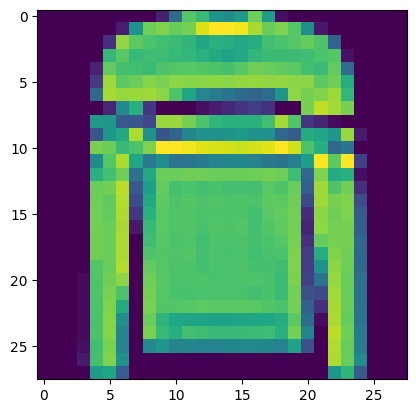

In [4]:
# loading minst dataset
# we don't need the "y" >> the output we only need to train our model in this data to genrate images
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, _), (x_test, _) = fashion_mnist.load_data()


# sample from data
plt.imshow(x_train[5])


# when working with convolutional neural networks (CNNs), it's common to have a fourth dimension representing the number of channels. For grayscale images, there's only one channel. So, we reshape the data to include this channel dimension (28x28x1)
# .astype('float32') part converts the data type of the elements in the array to 32-bit floating point numbers, which is a common data type used in deep learning frameworks due to its efficiency in computation
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
# normlize the pixel values between -1 and 1
# Subtracting 127.5 centers the pixel values around zero. The reason for choosing 127.5 is that it's halfway between the minimum (0) and maximum (255) pixel values in the 8-bit grayscale range.
# Dividing by 127.5 then scales the pixel values to be in the range [-1, 1]. This range is often preferred for neural networks because it allows the activation functions to operate more effectively, leading to faster convergence during training.
# Normalizing input data helps in training models more efficiently and can lead to better performance and stability during training.
x_train = (x_train - 127.5) / 127.5

# TensorFlow Datasets are a convenient way to work with data in TensorFlow, allowing for efficient streaming and parallel processing.
dataset = tf.data.Dataset.from_tensor_slices(x_train)
# Shuffling is important during training to prevent the model from memorizing the order of the training examples, which could lead to overfitting -- we use buffer size as an temporary memory to make a shuffel for 1024 img on it -- every batch contains 128 img
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)


In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    # 7*7*256 >> number of Neurons we made as a fully connected layer ,,, we made bias = false to (Reduced Computational Cost,Controlled Model Complexity: Bias parameters can increase the model's capacity to fit the training data, potentially leading to overfitting, especially if the dataset is small,Batch Normalization: In some cases, especially when using batch normalization layers, biases may become less necessary. Batch normalization already includes learnable parameters (scale and shift) that can perform similar functions as biases by controlling the mean and variance of the activations.)
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(tf.keras.layers.BatchNormalization())
    # the choice of leaky relu to( Avoiding "Dying ReLU" Problem,Handling Negative Inputs>>>Unlike ReLU, which outputs 0 for negative inputs, Leaky ReLU allows a small slope for negative inputs,Avoiding Vanishing Gradient)
    model.add(tf.keras.layers.LeakyReLU())


    # This layer reshapes the output of the previous layer into a 3D tensor with shape (7, 7, 256). This is required to prepare the data for the subsequent convolutional layers.
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
     # Note: None is the batch size 3la hasb b2a hykon kam ,, and when we make assert to make sure from the shape (7,7,256)
    assert model.output_shape == (None, 7, 7, 256)

    # Transposed convolution, also known as deconvolution, upconvolution, or fractionally-strided convolution, is the opposite operation of a regular convolution. While a regular convolution downsamples the input (reducing its spatial dimensions), a transposed convolution upsamples the input (increasing its spatial dimensions).
    # Transposed convolution is often used in tasks such as image generation, image segmentation, and various other tasks in computer vision. It helps in increasing the spatial resolution of the feature maps, which can be useful in tasks where retaining spatial information is important.
    # 128 >>> number of filters
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    # The increase in spatial dimensions from 7x7 to 14x14 to 28x28 is achieved through the use of transposed convolutional layers with specific strides. in Conv2DTranspose strides when increace >> double spatial dim
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28,28,1]))
    model.add(tf.keras.layers.LeakyReLU())
    # helps prevent overfitting
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

  #  flattens the 2D feature maps into a 1D vector, preparing the data for the final classification layer.
    model.add(tf.keras.layers.Flatten())
    # The final layer is a dense (fully connected) layer with 1 neuron, which outputs a single value.
    model.add(tf.keras.layers.Dense(1))

    return model

In [7]:
# make objects from 2 functions
genrator = make_generator_model()
discriminator = make_discriminator_model()

In [8]:
# Binary cross-entropy is commonly used as the loss function in binary classification problems, where the goal is to classify input data into one of two classes (e.g., real or fake). In the context of GANs, the discriminator's objective is to classify whether the input images are real or fake. The binary cross-entropy loss function measures the difference between the predicted output of the discriminator and the true labels (0 for fake and 1 for real)
# In the context of GANs, the discriminator's final layer often does not have an activation function applied to it, meaning it outputs raw logits. These logits represent the discriminator's confidence in its classification decision (e.g., positive values for real images and negative values for fake images). By setting from_logits=True, the binary cross-entropy loss function internally applies the sigmoid activation function to these logits to convert them into probabilities before calculating the loss. This ensures that the loss is computed correctly and effectively guides the training process.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
# fake_output: This parameter represents the output of the discriminator when given fake/generated images as input. It's the discriminator's prediction for these fake images.
# the generator's loss is computed based on how well the discriminator classifies the fake/generated images. The generator aims to minimize this loss, indicating that it generates images that are more likely to be classified as real by the discriminator.
# tf.ones_like(fake_output) is used as the target labels for the binary cross-entropy loss calculation.
def genrator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [11]:
# learning rate >>>  1e-4 (0.0001).
# Adam's adaptive learning rate(changes during training process), momentum(help us to get rid of local minmum), and efficient handling of gradients make it a suitable optimizer choice for training GANs, where stable and efficient optimization is crucial for achieving high-quality generated samples.
# over all >> These optimizers will be used during the training loop of the GAN to update the parameters of the generator and discriminator models, respectively, in order to minimize their respective loss functions and improve their performance.
genrator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
# single training step for the GAN model
from operator import ge
def train_step(images):
  # genrate noise (fake images) from normal distrbution -- all of data (real and fake is a ditrubtion and we want to make them identical)
  fake_img_noise = tf.random.normal([BATCH_SIZE, noise_dim])
  # are used to record the operations for computing the gradients of the generator and discriminator, respectively. ---- like what we do in ML if there is a loss and we want to minize it by applying differentiaion to minmize it and calculation gradiants
  with tf.GradientTape() as genrator_tape, tf.GradientTape() as discriminator_tape:
    # genrate fake images from noise
    generated_images = genrator(fake_img_noise, training=True)

    # we give discriminator real and fake data to do training on it
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images,  training=True)

    # calculate loss
    gen_loss = genrator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = genrator_tape.gradient(gen_loss, genrator.trainable_variables)
    gradients_of_discriminator = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)

    genrator_optimizer.apply_gradients(zip(gradients_of_generator, genrator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    print("genrator_loss",np.mean(gen_loss))
    print("discriminator_loss",np.mean(disc_loss))

In [13]:
# train the GAN model
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)

In [14]:
train(dataset, EPOCHS)

Streaming output truncated to the last 5000 lines.
genrator_loss tf.Tensor(1.2428309, shape=(), dtype=float32)
discriminator_loss tf.Tensor(1.191015, shape=(), dtype=float32)
genrator_loss tf.Tensor(1.1947472, shape=(), dtype=float32)
discriminator_loss tf.Tensor(1.121795, shape=(), dtype=float32)
genrator_loss tf.Tensor(1.2194874, shape=(), dtype=float32)
discriminator_loss tf.Tensor(1.1216867, shape=(), dtype=float32)
genrator_loss tf.Tensor(1.1042154, shape=(), dtype=float32)
discriminator_loss tf.Tensor(1.06326, shape=(), dtype=float32)
genrator_loss tf.Tensor(1.0270747, shape=(), dtype=float32)
discriminator_loss tf.Tensor(1.1299909, shape=(), dtype=float32)
genrator_loss tf.Tensor(1.0904056, shape=(), dtype=float32)
discriminator_loss tf.Tensor(1.0649161, shape=(), dtype=float32)
genrator_loss tf.Tensor(0.9914719, shape=(), dtype=float32)
discriminator_loss tf.Tensor(1.19468, shape=(), dtype=float32)
genrator_loss tf.Tensor(0.9395968, shape=(), dtype=float32)
discriminator_loss t

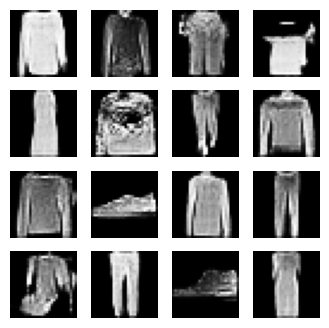

In [15]:
# to save our model to use it without making training each time
genrator.save_weights('genrator.h5')

# loading model
genrator.load_weights('genrator.h5')

# giving the model random noise to work on it
noise = tf.random.normal([num_examples_to_generate,noise_dim])
generated_images = genrator(noise, training=False)


fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
  plt.subplot(4, 4, i+1)
  # This line visualizes the ith generated image. It rescales the pixel values from the range [-1, 1] back to the original range [0, 255] and plots the image using a grayscale colormap.
  plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  # romving axis from the images
  plt.axis('off')
plt.show()